# Constrained Sensing with SHRED in a TRIGA Mark II Reactor: synthetic data

The OpenFOAM mesh contains almost 1 milion cells and, for storage reasons, only the compressed version with SVD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the variables
var_names = ['U', 'T', 'p', 'k', 'omega']
tex_var_names = [r'\mathbf{u}', r'T', r'p', r'\kappa', r'\omega']

# Define the path
path_data  = '../../NuSHRED_Datasets/D4/'

# Load the mesh data
mesh_data = np.load(path_data+'mesh_data.npz', allow_pickle=True)

# Load the singular values
sing_vals = {
    field: np.load(path_data+f'CompressedDataset/sing_vals_{field}.npz', allow_pickle=True)['sing_vals']
    for field in var_names
}

# Load the POD modes
full_pod_modes = {
    field: np.load(path_data+f'CompressedDataset/pod_modes_{field}.npz', allow_pickle=True)['modes']
    for field in var_names
}

# Load the POD coefficients
full_v_POD = {
    field: np.load(path_data+f'CompressedDataset/v_POD_{field}.npz', allow_pickle=True)['v_POD']
    for field in var_names
}

Nh = full_pod_modes['T'].shape[0]

# Load the time instants
fom_times = np.load(path_data+f'fom_times.npz', allow_pickle=True)['times']
Nt = fom_times.shape[0]


Let us make a plot of the mesh using `pyvista`, an `UnstructuredGrid` is created using cells and points.

In [2]:
import vtk
import pyvista as pv

grid = pv.UnstructuredGrid(
    mesh_data['cell_type'].item(),
    mesh_data['points'])
grid

UnstructuredGrid (0x32fd975e0)
  N Cells:    791566
  N Points:   899954
  X Bounds:   -8.566e-01, -3.329e-01
  Y Bounds:   3.831e-01, 9.068e-01
  Z Bounds:   1.228e-01, 1.023e+00
  N Arrays:   0

Let us plot the geometry

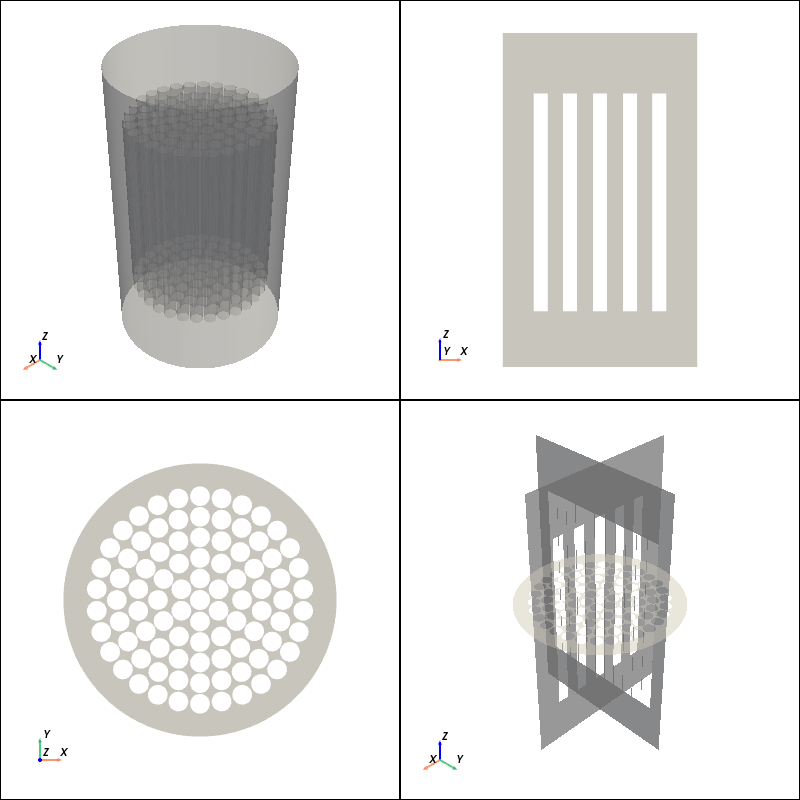

In [3]:
pl = pv.Plotter(shape=(2,2), window_size=(800, 800))

pl.subplot(0, 0)
pl.add_mesh(grid, show_edges=False, color='white', opacity=0.5)
pl.add_axes()

pl.subplot(0, 1)
pl.add_mesh(grid.slice(normal='y'), show_edges=False, color='white')
pl.add_axes()
pl.view_xz()

pl.subplot(1, 0)
pl.add_mesh(grid.slice(normal='z'), show_edges=False, color='white')
pl.add_axes()
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(grid.slice_orthogonal(), show_edges=False, color='white', opacity=0.75)
pl.add_axes()

pl.show(jupyter_backend='static')

Let us plot the singular values of the SVD decomposition

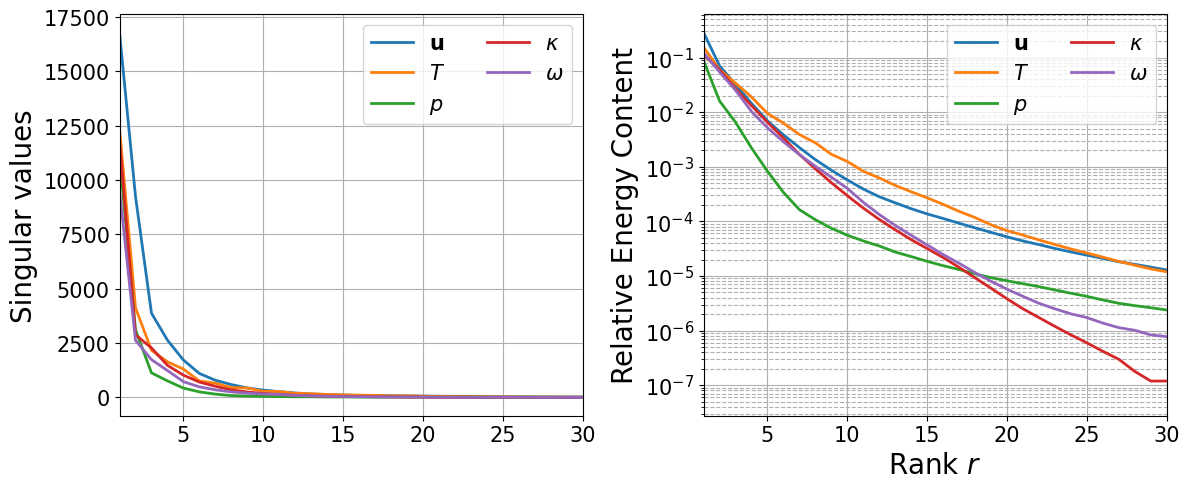

In [4]:
fig, axs = plt.subplots(1,2, sharex=True, figsize=(12,5))

for field_i, field in enumerate(var_names):
    axs[0].plot(np.arange(1,len(sing_vals[field])+1), sing_vals[field], label=r'$'+tex_var_names[field_i]+'$', linewidth=2)
    axs[1].semilogy(np.arange(1,len(sing_vals[field])+1), 1 - np.cumsum(sing_vals[field]**2) / np.sum(sing_vals[field]**2), label=r'$'+tex_var_names[field_i]+'$', linewidth=2)

axs[0].set_ylabel('Singular values', fontsize=20)
axs[1].set_ylabel('Relative Energy Content', fontsize=20)

for ax in axs:
    # ax.legend(fontsize=30, ncols=2)
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlim(1,30)
    ax.legend(fontsize=15, ncol=2, loc='upper right')

axs[-1].set_xlabel(r'Rank $r$', fontsize=20)

plt.tight_layout()

## Sensors and measurements
The sensors are location in two specific channels (ext and reg) of the reactor where the dynamics is less pronounced.

In [5]:
z_positions = np.linspace(0.35, .9, 25)

channels = [
            [-0.36674016726017, 0.6299546962976456], # External
            [-0.70274016726017, 0.7299546962976455]  # REG
            ]    

available_positions_idx_ext = list()
available_positions_idx_reg = list()
for z in z_positions:
    available_positions_idx_ext.append(grid.find_closest_point([channels[0][0], channels[0][1], z])) # External Only
    available_positions_idx_reg.append(grid.find_closest_point([channels[1][0], channels[1][1], z])) # REG Only

# Assure there are no duplicates
available_positions_idx_ext = list(set(available_positions_idx_ext))
available_positions_idx_reg = list(set(available_positions_idx_reg))

print(f'Available positions for external channel: {len(available_positions_idx_ext)}')
print(f'Available positions for REG channel: {len(available_positions_idx_reg)}')

Available positions for external channel: 15
Available positions for REG channel: 15


Let us plot the available sensor locations in the channels

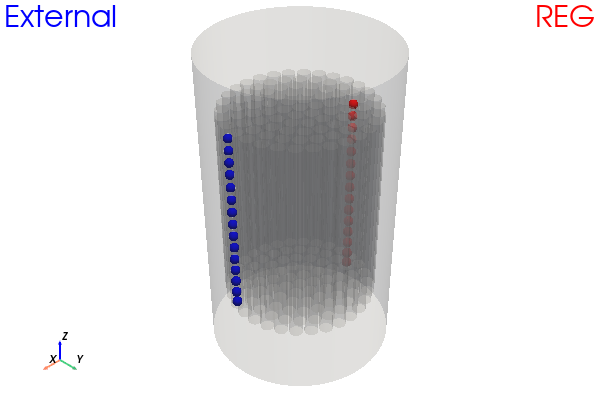

In [6]:
# Create a PyVista plotter
plotter = pv.Plotter(window_size=[600, 400], border=False)

plotter.add_mesh(grid, opacity=0.2, show_edges=False, color='white')
plotter.add_points(grid.points[available_positions_idx_ext], color='blue', point_size=10, render_points_as_spheres=True)
plotter.add_points(grid.points[available_positions_idx_reg], color='red', point_size=10, render_points_as_spheres=True)
plotter.zoom_camera(1.1)
plotter.set_background('white')
plotter.add_axes()

# Add the legend
plotter.add_text('External', position='upper_left', color='blue', font_size=12)
plotter.add_text('REG', position='upper_right', color='red', font_size=12)

plotter.show(jupyter_backend='static')

Let us extract the measurements: only the temperature field can be detected and the sensor can be mathematically represented as a linear operator:

$$
y_m^{clean} = v_m(T)= \int_{\Omega} \delta(\mathbf{x}-\mathbf{x}_m)\cdot T(\mathbf{x}) d\Omega
$$

To which random noise is added:

$$
y_m = y_m^{clean} \cdot (1+\epsilon_m)
$$

where $\epsilon_m$ is a random variable with zero mean and standard deviation $\sigma_m$.

In [8]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

measured_field = 1
num_sensors = 3

n_configurations = 3

np.random.seed(0)
idx_sensors_location = {
    'reg': np.array([np.random.choice(available_positions_idx_reg, num_sensors, replace=False) for _ in range(n_configurations)]),
    'ext': np.array([np.random.choice(available_positions_idx_ext, num_sensors, replace=False) for _ in range(n_configurations)])
}

# Compute the sensor measurements
snap_measurements = {
    'reg': [ (full_pod_modes[var_names[measured_field]][idx_sensors_location['reg'][kk]] @ full_v_POD[var_names[measured_field]]).T.reshape(1, Nt, num_sensors)
             for kk in range(n_configurations)],
    'ext': [ (full_pod_modes[var_names[measured_field]][idx_sensors_location['ext'][kk]] @ full_v_POD[var_names[measured_field]]).T.reshape(1, Nt, num_sensors)
             for kk in range(n_configurations)]
}


noise_value = 2e-2
noisy_measurements = {
    'reg': [snap_measurements['reg'][kk] + noise_value * np.random.randn(*snap_measurements['reg'][kk].shape) for kk in range(n_configurations)],
    'ext': [snap_measurements['ext'][kk] + noise_value * np.random.randn(*snap_measurements['ext'][kk].shape) for kk in range(n_configurations)]
}

Let us make a plot of the sensor locations and the measurements

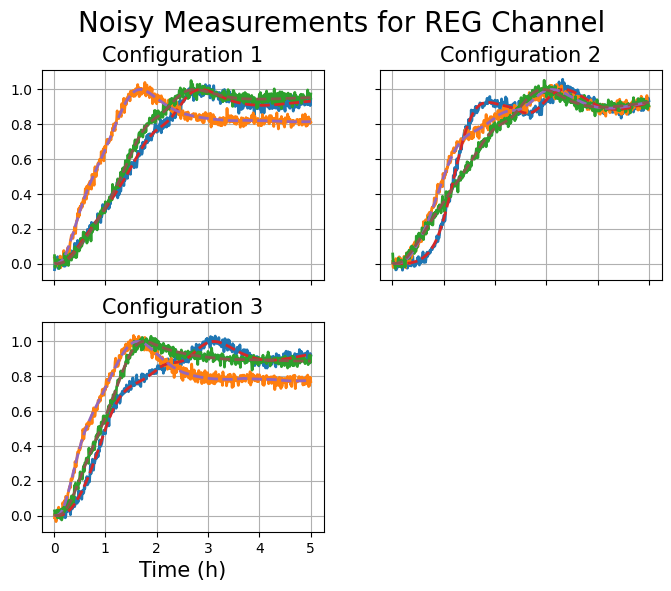

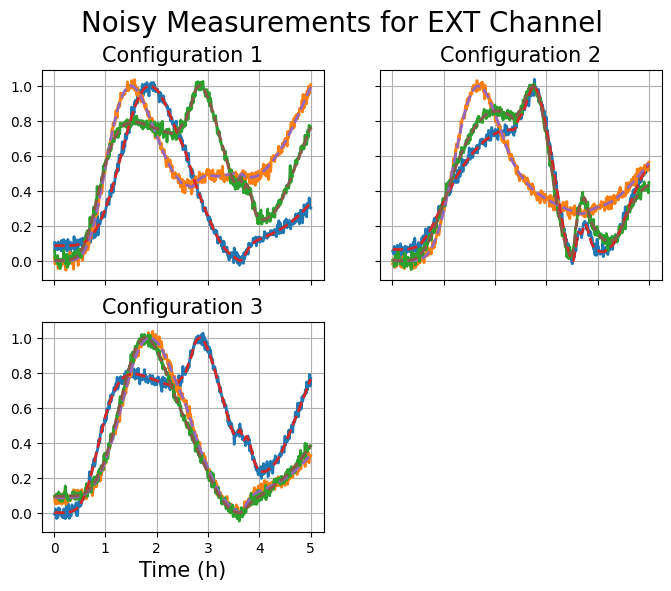

In [9]:
for chan in noisy_measurements.keys():

    nrows = 2
    ncols = 2
    fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=(4 * ncols, 3 * nrows), sharey=True)
    axs = axs.flatten()

    for kk in range(n_configurations):
        axs[kk].plot(fom_times, noisy_measurements[chan][kk][0], linewidth=2)
        axs[kk].plot(fom_times, snap_measurements[chan][kk][0], '--', linewidth=2, label='Original')
        axs[kk].set_title(f'Configuration {kk+1}', fontsize=15)

        if kk >= ncols:
            axs[kk].set_xlabel('Time (h)', fontsize=15)

        axs[kk].grid()

    if n_configurations < nrows * ncols:
        for kk in range(n_configurations, nrows * ncols):
            axs[kk].axis('off')

    fig.suptitle(f'Noisy Measurements for {chan.upper()} Channel', fontsize=20)

## Pre-processing the data and padding
The POD coefficients and the measurements are processed by the Padding function. Let us rescale the POD coefficients and the measurements to the range $[0,1]$.

Note: the measurements are already between $[0,1]$

In [10]:
from tools import MyScaler # this includes the scaler method for standard deviation

rank = 15
Nmodes = [rank] * len(var_names)
v_total = np.concatenate([full_v_POD[field][:rank].T for field in var_names], axis=1).reshape(1, Nt, -1)

pod_scaler = MyScaler('minmax')
pod_scaler.fit(v_total[0].T)

Let us apply the padding function

In [11]:
import sys
sys.path.append('/Users/sriva/Github/PublicRepo/NuSHRED') # Adjust this path as necessary

from shred.processdata import Padding, TimeSeriesDataset
import torch

# GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 25

# Define the data input and output for the TimeSeriesDataset
data_in  = {
    chan: [Padding(torch.from_numpy(noisy_measurements[chan][kk]), lags).to(device) for kk in range(n_configurations)]
    for chan in noisy_measurements.keys()
}
data_out = Padding(torch.from_numpy(np.array([pod_scaler.transform(v_total[0].T).T])), 1).squeeze(1).to(device)

# Reconstruction - splitting into train, test and validation
np.random.seed(0)
train_indices = np.sort(np.random.choice(Nt, size=340, replace=False))
mask = np.ones(Nt)
mask[train_indices] = 0
valid_test_indices = np.arange(0, Nt)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

### Generate training validation and test datasets both for reconstruction of states
train_dataset = dict()
valid_dataset = dict()
test_dataset  = dict()

for chan in noisy_measurements.keys():
    train_dataset[chan] = [TimeSeriesDataset(data_in[chan][kk][train_indices], data_out[train_indices]) for kk in range(n_configurations)]
    valid_dataset[chan] = [TimeSeriesDataset(data_in[chan][kk][valid_indices], data_out[valid_indices]) for kk in range(n_configurations)]
    test_dataset[chan]  = [TimeSeriesDataset(data_in[chan][kk][test_indices],  data_out[test_indices])  for kk in range(n_configurations)]


## SHRED

### Training
The SHRED model is trained using the `SHRED` class.

In [12]:
from shred.models import SHRED, fit
import os

train_net = True
shred = dict()

for chan in noisy_measurements.keys():
    path_shred = f'SHRED/{chan}/'
    os.makedirs(path_shred, exist_ok=True)
    shred[chan] = list()
    for kk in range(n_configurations):
        shred[chan].append(SHRED(num_sensors, sum(Nmodes), 
                                 hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], 
                                 dropout = 0.1).to(device))

        if train_net:
            print(f'Training SHRED {chan} - Configuration {kk+1}')

            fitting_errors = fit(   shred[chan][kk], train_dataset[chan][kk], valid_dataset[chan][kk],
                                    batch_size = 64, epochs = 3000, lr = 5e-4, 
                                    verbose = True, patience = 50)

            shred[chan][kk].freeze()
            torch.save(shred[chan][kk].state_dict(), path_shred+'trained_shred_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'_config'+str(kk+1)+'.shred')
            print(' ')
        else:
            shred[chan][kk].load_state_dict(torch.load(path_shred+'trained_shred_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'_config'+str(kk+1)+'.shred',
                                                    map_location=device))
            shred[chan][kk].freeze()



Training SHRED reg - Configuration 1
Training done: Training loss = 8.92% 	 Validation loss = 9.57%        
 
Training SHRED reg - Configuration 2
Training done: Training loss = 6.18% 	 Validation loss = 6.56%        
 
Training SHRED reg - Configuration 3
Training done: Training loss = 13.29% 	 Validation loss = 13.54%      
 
Training SHRED ext - Configuration 1
Training done: Training loss = 3.34% 	 Validation loss = 3.73%        
 
Training SHRED ext - Configuration 2
Training done: Training loss = 3.28% 	 Validation loss = 3.74%        
 
Training SHRED ext - Configuration 3
Training done: Training loss = 3.54% 	 Validation loss = 4.08%        
 


### Test Phase on the POD coefficients
Let us compare how the SHRED model performs with respect to the test set

In [13]:
from shred.processdata import mre, num2p
import torch

Ytest_POD_hat = {
    chan: torch.stack([shred[chan][kk](test_dataset[chan][kk].X) for kk in range(n_configurations)], dim=0)
    for chan in noisy_measurements.keys()
}

Ytest_POD_pred = dict()
for chan in noisy_measurements.keys():
    Ytest_POD_pred[chan] = {
        'mean': Ytest_POD_hat[chan].mean(axis=0)[:, :sum(Nmodes)],
        'std':  Ytest_POD_hat[chan].std(axis=0)[:,:sum(Nmodes)] / np.sqrt(n_configurations),
        'cov':  torch.stack([torch.cov(Ytest_POD_hat[chan][:, i, :sum(Nmodes)].T) for i in range(Ytest_POD_hat[chan].shape[1])]) / n_configurations
    }

print(f"Mean relative SHRED prediction error on POD coeffs for reg channel: {num2p(mre(test_dataset['reg'][0].Y[:, :sum(Nmodes)], Ytest_POD_pred['reg']['mean']))} +- {num2p((Ytest_POD_pred['reg']['std'].pow(2).sum(axis = -1).sqrt() / (test_dataset['reg'][0].Y[:, :sum(Nmodes)]).pow(2).sum(axis = -1).sqrt()).mean())}" )
print(f"Mean relative SHRED prediction error on POD coeffs for ext channel: {num2p(mre(test_dataset['ext'][0].Y[:, :sum(Nmodes)], Ytest_POD_pred['ext']['mean']))} +- {num2p((Ytest_POD_pred['ext']['std'].pow(2).sum(axis = -1).sqrt() / (test_dataset['ext'][0].Y[:, :sum(Nmodes)]).pow(2).sum(axis = -1).sqrt()).mean())}" )

Mean relative SHRED prediction error on POD coeffs for reg channel: 8.15% +- 4.18%
Mean relative SHRED prediction error on POD coeffs for ext channel: 3.07% +- 1.27%


Let us reshape the POD coefficients and let us transform them back into the right scale.

In fact, the output of the SHRED models is a 2D array with dimensions $ N_t \times R$, where $N_t$ the number of time steps, $R$ the number of total rank of the latent space.

In [16]:
_test_recons_v_POD = dict()
_test_truth_v_POD  = dict()

for chan in noisy_measurements.keys():
    _test_recons_v_POD[chan] = dict()
    _test_truth_v_POD[chan]  = dict()
    for field_i, field in enumerate(var_names):
        _test_recons_v_POD[chan][field]  = {
            'mean': np.array([pod_scaler.inverse_transform(    Ytest_POD_pred[chan]['mean'].cpu().detach().numpy().T).T])[:, :, sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])],
            'std':  np.array([pod_scaler.inverse_std_transform(Ytest_POD_pred[chan]['std' ].cpu().detach().numpy().T).T])[:, :, sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])],
            'full': np.array([pod_scaler.inverse_transform(    
                Ytest_POD_hat[chan][kk].cpu().detach().numpy().T).T
                for kk in range(n_configurations)
            ])[:, :, sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])]
        }

        _test_truth_v_POD[chan][field]  = {
        'mean': np.array([pod_scaler.inverse_transform(    torch.stack([test_dataset[chan][kk].Y for kk in range(n_configurations)], dim=0).mean(axis=0).cpu().detach().numpy().T).T])[:, :, sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])] ,
        'std' : np.array([pod_scaler.inverse_std_transform(torch.stack([test_dataset[chan][kk].Y for kk in range(n_configurations)], dim=0).std( axis=0).cpu().detach().numpy().T).T])[:, :, sum(Nmodes[:field_i]):sum(Nmodes[:field_i+1])]
    }

Let us plot the output of SHRED with respect to the true POD coefficients.

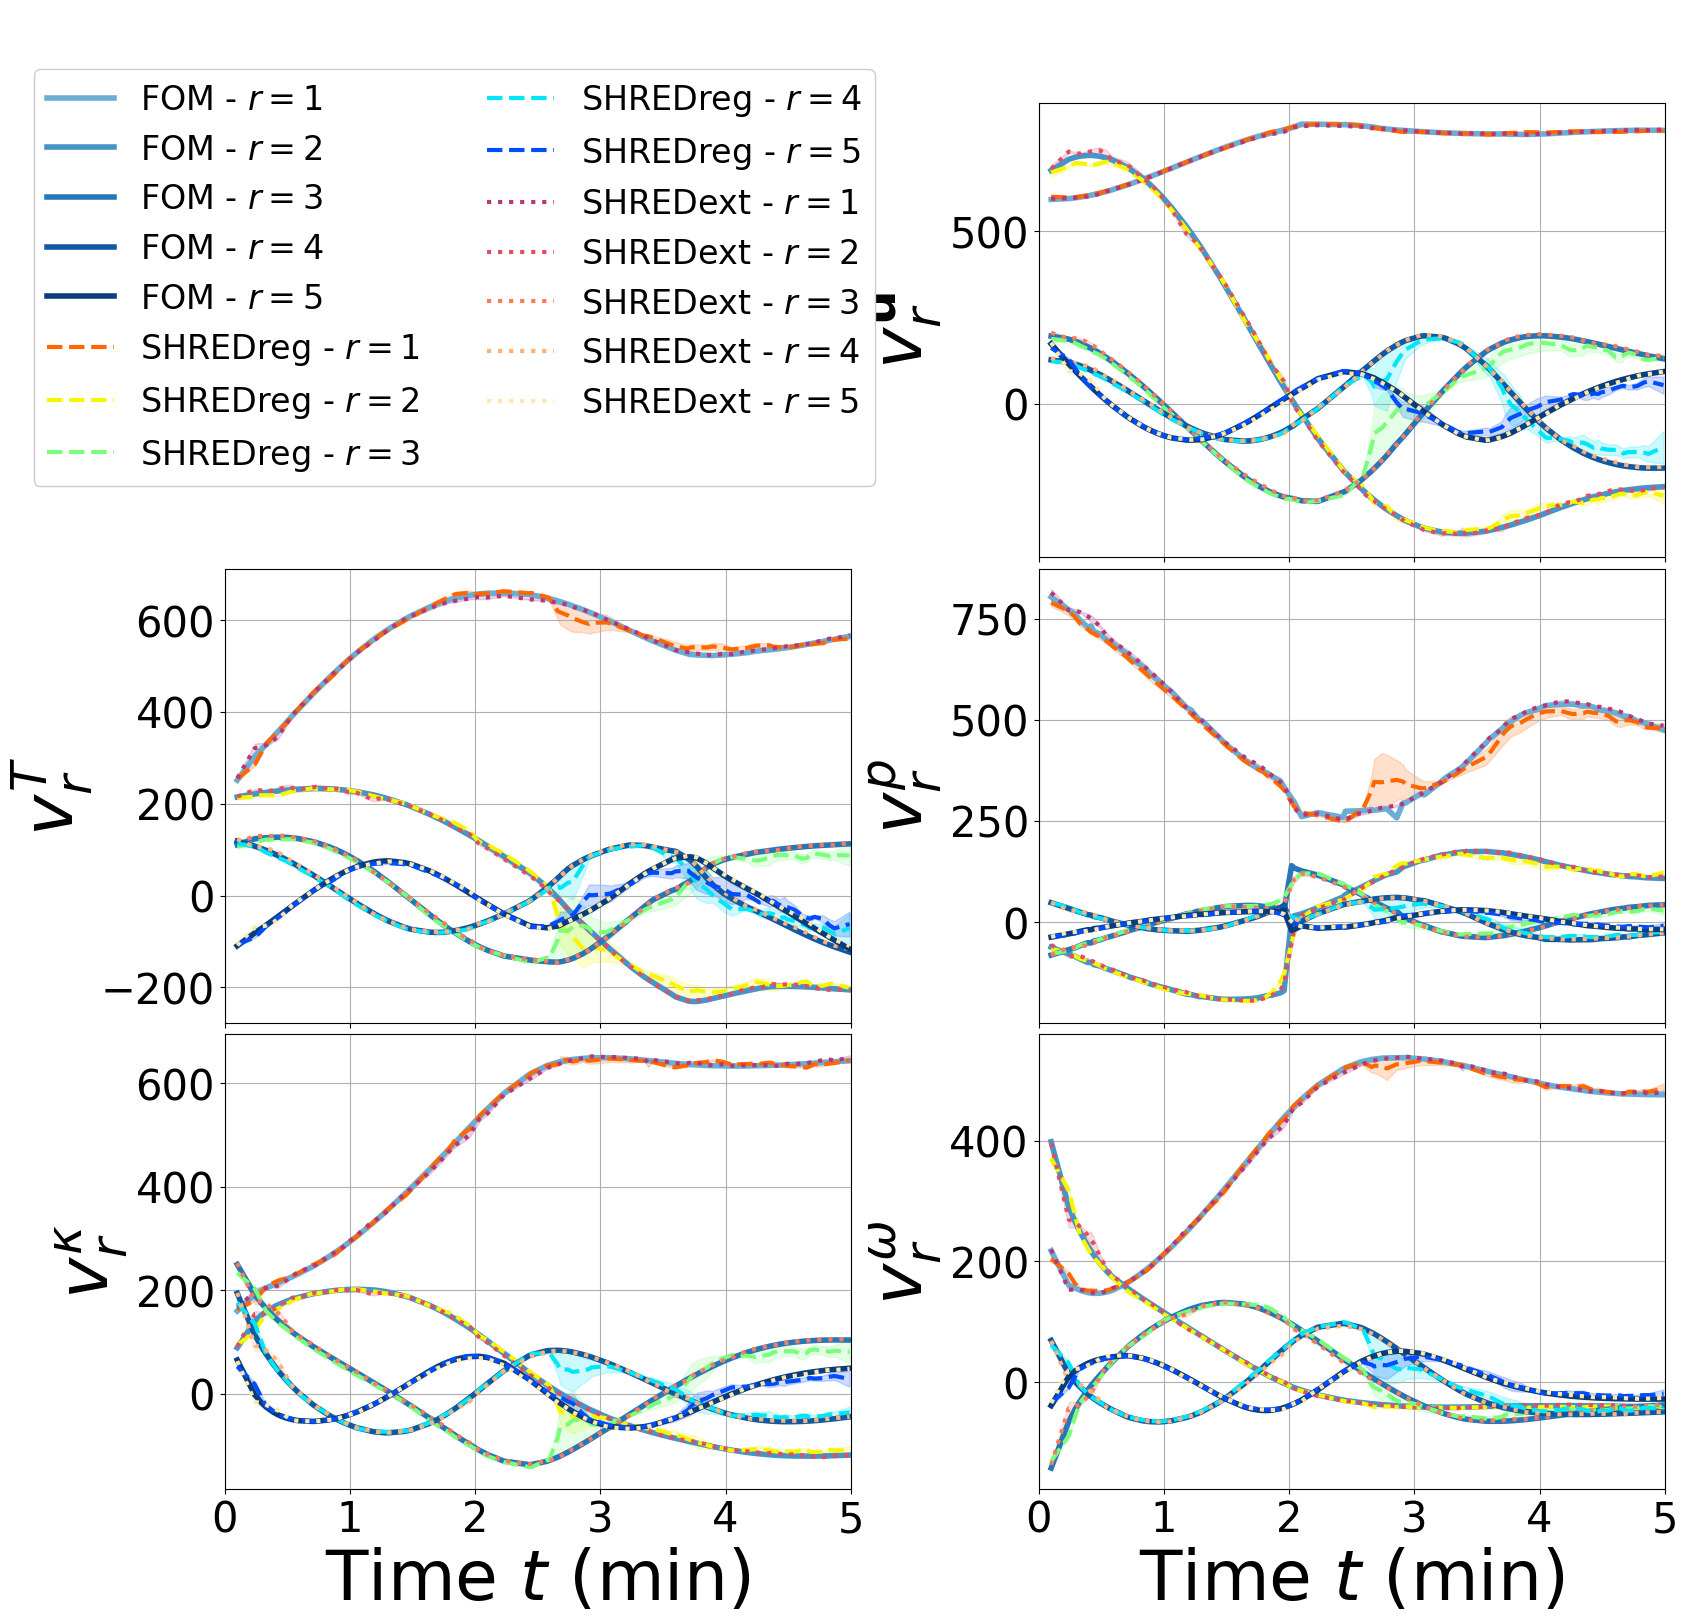

In [24]:
from matplotlib import cm

modes_to_plot = np.arange(0,5,1)
param_to_plot = 0

nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize=(8 * ncols, 6 * nrows))
axs = axs.flatten()

line_styles = ['--', ':']

ls = 3
for field_i, field in enumerate(var_names):
    colors_truth = cm.Blues(  np.linspace(0.5, 0.95, len(modes_to_plot)))
    colors_ext   = cm.jet_r(  np.linspace(0.2, 0.8, len(modes_to_plot)))
    colors_reg   = cm.magma( np.linspace(0.5, 0.95, len(modes_to_plot)))

    for ii, mode in enumerate(modes_to_plot):
        axs[field_i+1].plot(fom_times[test_indices], _test_truth_v_POD['reg'][field]['mean'][param_to_plot,:,mode],
                          '-', linewidth=ls+1, c=colors_truth[ii], label=r'FOM - $r='+str(mode+1)+'$')
        
        for jj, chan in enumerate(noisy_measurements.keys()):
            axs[field_i+1].plot(fom_times[test_indices], _test_recons_v_POD[chan][field]['mean'][param_to_plot,:,mode],
                                line_styles[jj], linewidth=ls, c=[colors_ext[ii], colors_reg[ii]][jj], label=r'SHRED'+chan+' - $r='+str(mode+1)+'$')
            axs[field_i+1].fill_between(fom_times[test_indices],
                                        _test_recons_v_POD[chan][field]['mean'][param_to_plot,:,mode] - _test_recons_v_POD[chan][field]['std'][param_to_plot,:,mode],
                                        _test_recons_v_POD[chan][field]['mean'][param_to_plot,:,mode] + _test_recons_v_POD[chan][field]['std'][param_to_plot,:,mode],
                                        color=[colors_ext[ii], colors_reg[ii]][jj], alpha=0.2)
        
    axs[field_i+1].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=50)
    axs[field_i+1].grid()
    
    axs[field_i+1].set_xlim(0, fom_times[-1])
    axs[field_i+1].tick_params(axis='both', labelsize=30)
    
    # axs[field_i].set_xticks((np.array([0.5, 1.5, 2.5]) + new_t[-1] * np.arange(len(param_to_plot))[:, None]).flatten())
    # axs[field_i].set_xticklabels(np.hstack([[0.5, 1.5, 2.5] for _ in range(len(param_to_plot))]))

for field_i in range(nrows * ncols- len(var_names)):
    axs[field_i].axis('off')

Line, Label = axs[1].get_legend_handles_labels()
Label = np.stack([Label[ii::3] for ii in range(3)], axis=0).flatten()
Line = np.stack([Line[ii::3] for ii in range(3)], axis=0).flatten()

fig.legend(Line, Label, fontsize=24, ncols=2, framealpha=1, loc=(0.02, 0.7))

# axs = axs.reshape(nrows, ncols)

[ax.set_xlabel(r'Time $t$ (min)', fontsize=50) for ax in [axs[-2], axs[-1]]]

fig.subplots_adjust(left=0, hspace=0.025, wspace=0.3)

**Decoding to the high-dimensional fields**:
Let us decode the output of the SHRED model to the high-dimensional fields: the FOM is represented by a high-rank SVD for the sake of reducing the storage.

In [25]:
ave_rel_errors = {
        'mean': {key: np.zeros((len(var_names), 1, len(test_indices))) for key in noisy_measurements.keys()},
        'std':  {key: np.zeros((len(var_names), 1, len(test_indices))) for key in noisy_measurements.keys()}
    }

for field_i, field in enumerate(var_names):
    fom = full_pod_modes[field] @ full_v_POD[field][:, test_indices]
    pred = {
        'mean': {key: full_pod_modes[field][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][field]['mean'][0].T for key in noisy_measurements.keys()},
        'std' : {key: full_pod_modes[field][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][field]['std'][0].T  for key in noisy_measurements.keys()}
    }

    for key in noisy_measurements.keys():
        pred = {
            'mean': full_pod_modes[field][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][field]['mean'][0].T,
            'std' : full_pod_modes[field][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][field]['std'][0].T
        }
        ave_rel_errors['mean'][key][field_i, 0] = np.linalg.norm(fom - pred['mean'], axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][key][field_i, 0]  = np.linalg.norm(pred['std'], axis=0)   / np.linalg.norm(fom, axis=0)


Let us plot the errors bars for the decoded fields

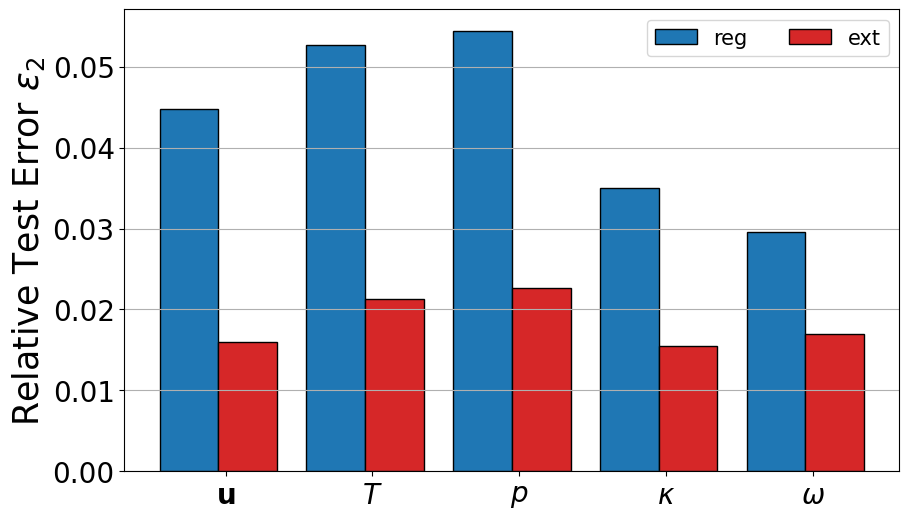

In [26]:
keys = list(ave_rel_errors['mean'].keys())

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

bar_width = 0.4  # Adjusted width to bring bars closer
colors = {'key1': 'tab:blue', 'key2': 'tab:red'}  # Fixed colors for consistency

key = keys[0]
axs.bar(np.arange(0, len(var_names)), ave_rel_errors['mean'][key].mean(axis=2).flatten(), 
        # yerr=ave_rel_errors['mean'][key].std(axis=2).flatten(), 
        capsize=5,
        color=colors['key1'],
        edgecolor='k', width=bar_width, label=key)

key = keys[1]
axs.bar(np.arange(0, len(var_names)) + bar_width, ave_rel_errors['mean'][key].mean(axis=2).flatten(),
        # yerr=ave_rel_errors['mean'][key].std(axis=2).flatten(), 
        capsize=5,
        color=colors['key2'],
        edgecolor='k', width=bar_width, label=key)

# axs.set_yscale('log')
axs.set_xticks(np.arange(0.25,len(var_names),1), ['$'+tex_+'$' for tex_ in tex_var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')
axs.legend(fontsize=15, ncols=2)


### Contour Plots
For the test data, let us plot the contour plots of the decoded fields.

In [27]:
cmap = [
        cm.RdYlBu_r, 
        cm.managua_r,
        cm.bwr,
        cm.PiYG,
        cm.vanimo,
        ]

cmap_std = cm.magma_r

clims = [
    [0, 0.55],
    [290, 385]
    # [290, 332]
]

Let us load the scalers

In [28]:
# Load the scalers
scalers = {
    field: np.load(path_data+f'CompressedDataset/scalers_{field}.npz', allow_pickle=True)['scaler'].item()
    for field in var_names
}

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


A slice at the core center is taken, normal to $z$

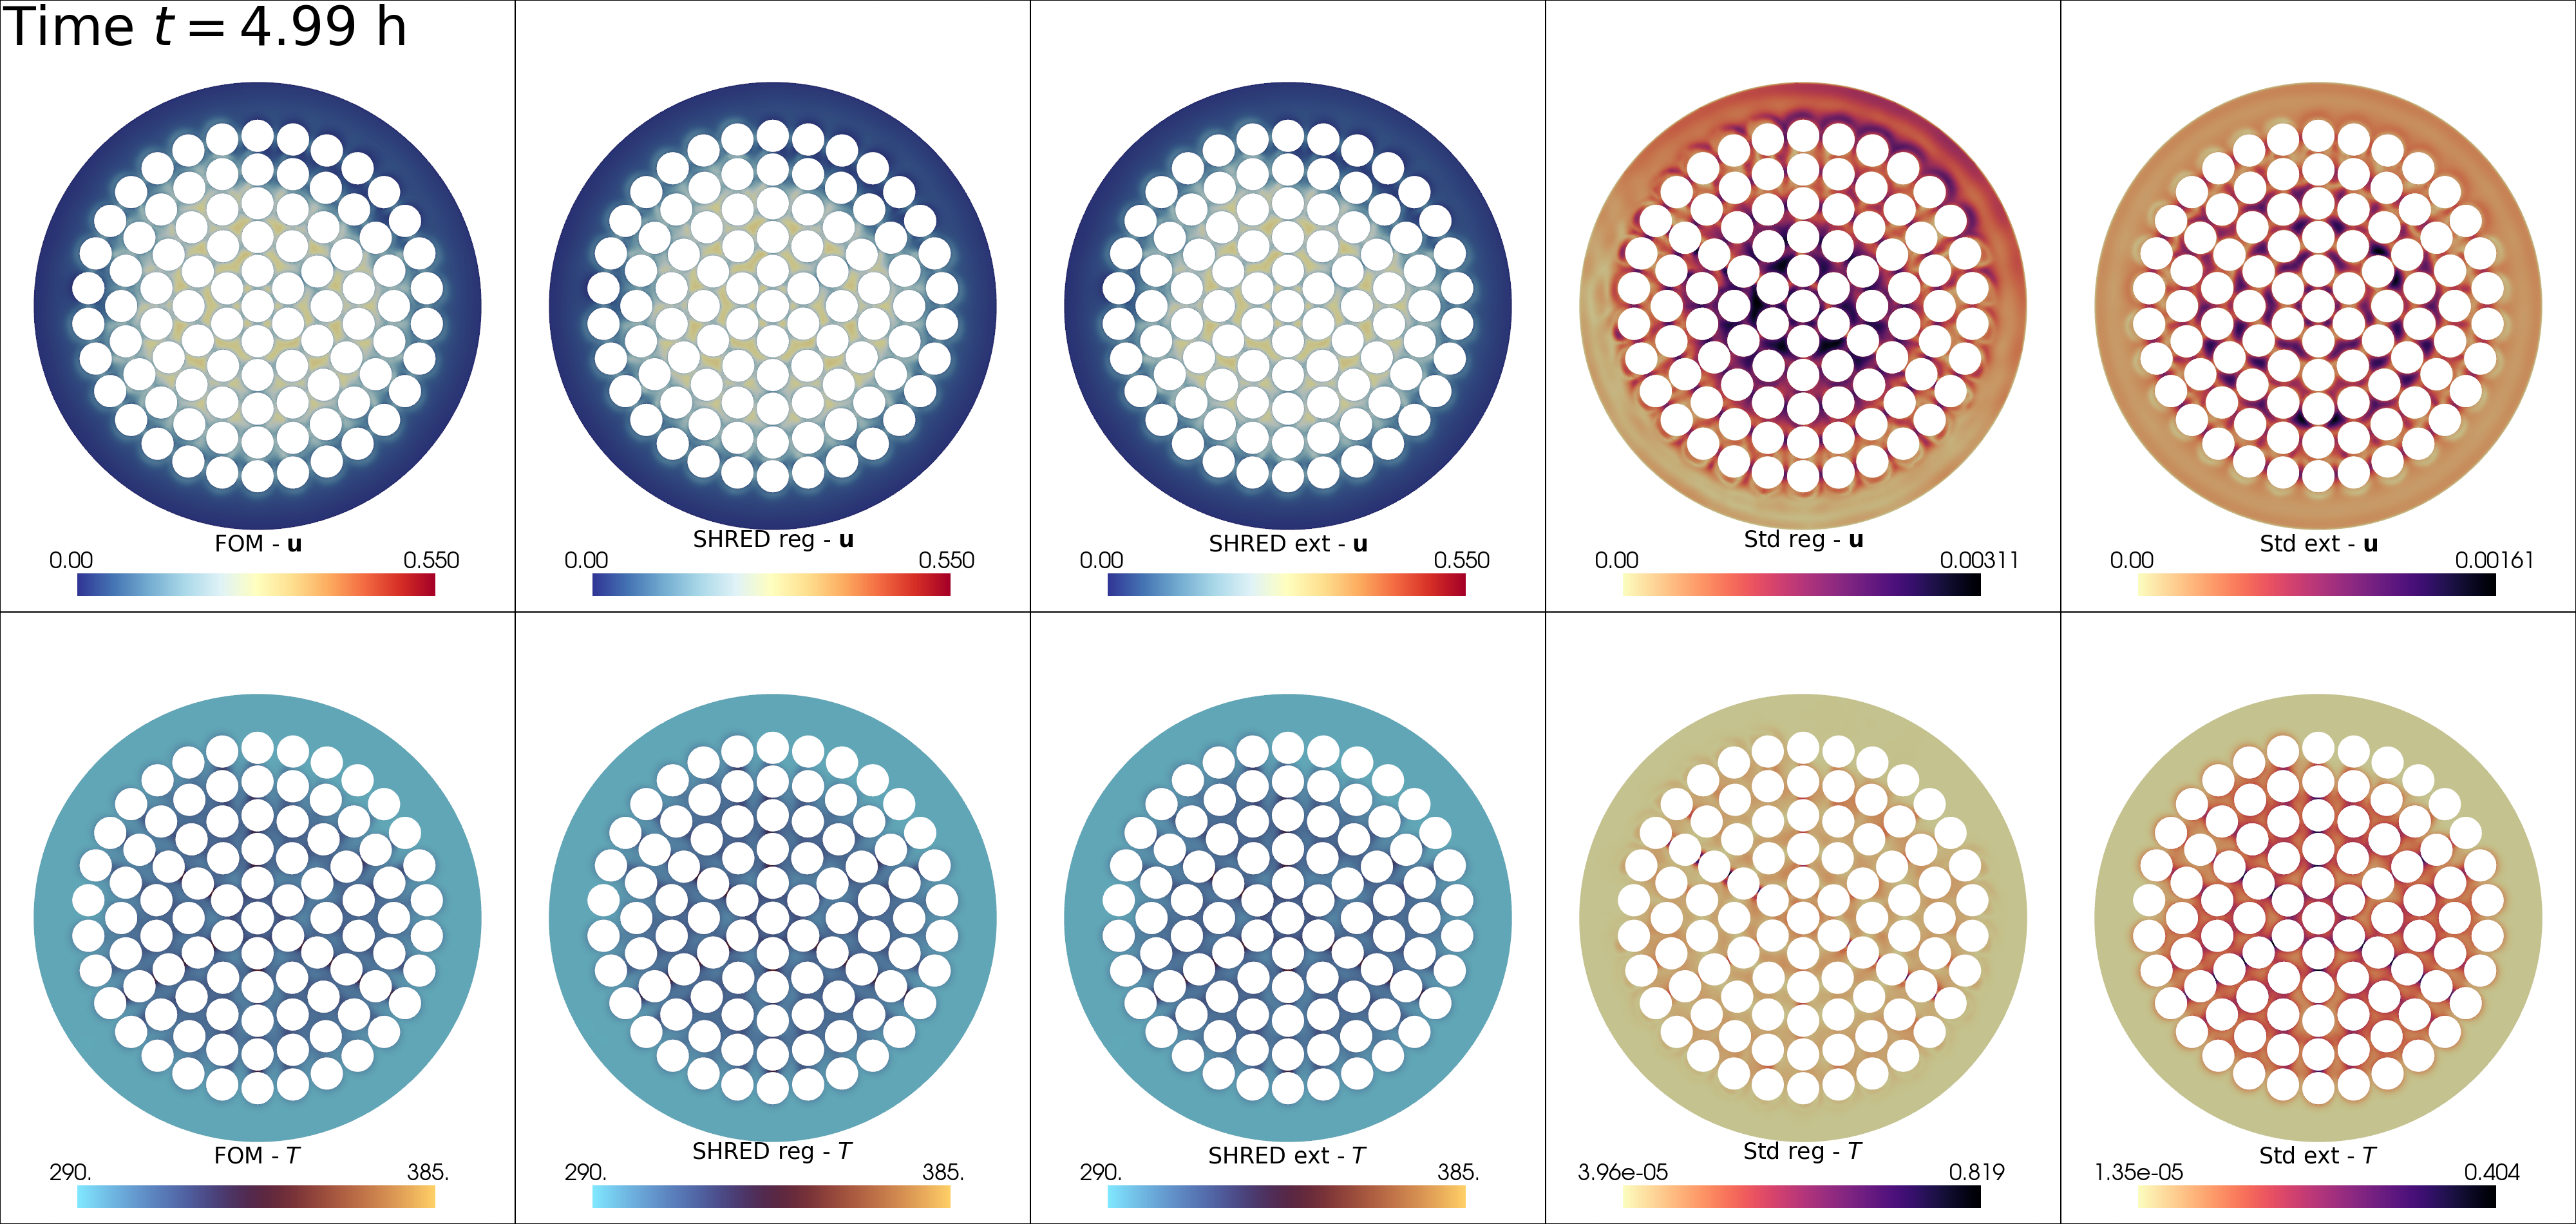

In [38]:
fields_to_plot = [0,1]

zoom = 1.25

dict_cb = dict(     width = 0.7, height = 0.1,
                    title_font_size=35,
                    label_font_size=35,
                    n_labels=2,
                    color = 'black',
                    position_x=0.15, position_y=0.025,
                    shadow=False) 

nrows = len(fields_to_plot)
ncols = 5
resolution = [800*ncols, 950*nrows]

keys = list(noisy_measurements.keys())

ii = -1
tt_to_plot = test_indices[ii]

pl = pv.Plotter(off_screen=False, shape=(nrows, ncols), window_size=resolution)

for jj, field_i in enumerate(fields_to_plot):

    if field_i == 0:
        grid['fom']        = (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]] @ full_v_POD[var_names[field_i]][:, tt_to_plot].reshape(-1,1)).T)).reshape(Nh, 3)
        for key in keys:
            grid['shred-mean-'+key] = (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['mean'][0].T[:, ii].reshape(-1,1)).T)).reshape(Nh, 3)
            _std_recon = np.zeros_like(grid['shred-mean-'+key])
            for kk in range(n_configurations):
                _std_recon += ((scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['full'][kk][ii].reshape(-1,1)).T)).reshape(Nh, 3) - grid['shred-mean-'+key])**2 / (n_configurations - 1)
            grid['shred-std-'+key]  = np.sqrt(_std_recon) / np.sqrt(n_configurations)
            # grid['shred-std-'+key]  = (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['std'][0].T[:, ii].reshape(-1,1)).T) - scalers[var_names[field_i]].data_min_).reshape(Nh, 3)
    else:
        grid['fom']        = scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]] @ full_v_POD[var_names[field_i]][:, tt_to_plot].reshape(-1,1)).T)[0]
        for key in keys:
            grid['shred-mean-'+key] = scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['mean'][0].T[:, ii].reshape(-1,1)).T)[0]
            _std_recon = np.zeros_like(grid['shred-mean-'+key])
            for kk in range(n_configurations):
                _std_recon += (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['full'][kk][ii].reshape(-1,1)).T)[0] - grid['shred-mean-'+key])**2 / (n_configurations - 1)
            grid['shred-std-'+key]  = np.sqrt(_std_recon) / np.sqrt(n_configurations)
            # grid['shred-std-'+key]  = scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['std'][0].T[:, ii].reshape(-1,1)).T)[0] - scalers[var_names[field_i]].data_min_
            
    pl.subplot(jj, 0)
    dict_cb['title'] = r'FOM - $'+tex_var_names[field_i]+'$'
    pl.add_mesh(grid.slice(normal='z'), scalars='fom', cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i])
    pl.view_xy()
    pl.zoom_camera(zoom)

    pl.subplot(jj, 1)
    dict_cb['title'] = r'SHRED '+keys[0]+' - $'+tex_var_names[field_i]+'$'
    pl.add_mesh(grid.slice(normal='z'), scalars='shred-mean-'+keys[0], cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i])
    pl.view_xy()
    pl.zoom_camera(zoom)

    pl.subplot(jj, 2)
    dict_cb['title'] = r'SHRED '+keys[1]+' - $'+tex_var_names[field_i]+'$'
    pl.add_mesh(grid.slice(normal='z'), scalars='shred-mean-'+keys[1], cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i])
    pl.view_xy()
    pl.zoom_camera(zoom)

    if ncols == 5:
        pl.subplot(jj, 3)
        dict_cb['title'] = r'Std '+keys[0]+' - $'+tex_var_names[field_i]+'$'
        pl.add_mesh(grid.slice(normal='z'), scalars='shred-std-'+keys[0], cmap=cmap_std, scalar_bar_args=dict_cb)
        pl.view_xy()
        pl.zoom_camera(zoom)

        pl.subplot(jj, 4)
        dict_cb['title'] = r'Std '+keys[1]+' - $'+tex_var_names[field_i]+'$'
        pl.add_mesh(grid.slice(normal='z'), scalars='shred-std-'+keys[1], cmap=cmap_std, scalar_bar_args=dict_cb)
        pl.view_xy()
        pl.zoom_camera(zoom)

pl.subplot(0, 0)
pl.add_text(r'Time $t = {:.2f}'.format(fom_times[tt_to_plot])+'$ h', position='upper_left', font_size=35, color='black')

pl.set_background('white', top='white')
pl.show(jupyter_backend='static')

del pl

A slice at the core center is taken, normal to $y$

In [ ]:
class PvPlotter(pv.Plotter):
    def __init__(self, grid, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.grid = grid

    def update_field(self, snap, name: str = 'u', row=0, col=0, cmap='jet', slice = None, **kwargs):
        self.grid[name] = snap
        self.subplot(row, col)
        if slice == 'x' or slice == 'y' or slice == 'z':
            self.add_mesh(self.grid.slice(normal=slice), scalars=name, cmap=cmap, name=name, **kwargs)
        elif slice == 'orthogonal':
            self.add_mesh(self.grid.slice_orthogonal(), scalars=name, cmap=cmap, name=name, **kwargs)
        else:
            self.add_mesh(self.grid, scalars=name, cmap=cmap, name=name, **kwargs)

dict_cb = dict(     width = 0.1, height = 0.65,
                    title_font_size=1,
                    label_font_size=35,
                    n_labels=5,
                    color = 'black',
                    position_x=0.8, position_y=0.15,
                    shadow=False, vertical=True) 

clims = [
    [0, 0.55],
    [290, 335],
    [scalers[var_names[2]].data_max_.min(), scalers[var_names[2]].data_max_.max()],
    [scalers[var_names[3]].data_max_.min(), scalers[var_names[3]].data_max_.max()],
    [scalers[var_names[4]].data_max_.min(), scalers[var_names[4]].data_max_.max()]
]

fields_to_plot = [0, 1]

save_figs = True
path_figs = 'Test_Results/Figs/'

nrows = 3
ncols = 3
window_size = [800*ncols, 900*nrows]

zoom = 1.18

for field_i in fields_to_plot:

    if save_figs:
        os.makedirs(path_figs+var_names[field_i]+'/', exist_ok=True)


    myPl = PvPlotter(grid, off_screen=False, window_size=window_size, shape=(nrows, ncols), border=False)

    sampling = 2
    for ii, tt_to_plot in enumerate(test_indices[::sampling]):

        myPl.clear()

        if field_i == 0:
            myPl.update_field((scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]] @ full_v_POD[var_names[field_i]][:, tt_to_plot].reshape(-1,1)).T)).reshape(Nh, 3),
                            'fom', row=0, col=0, cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i], slice='y')
            for key_i, key in enumerate(keys):
                recon = (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['mean'][0].T[:, ii*sampling].reshape(-1,1)).T)).reshape(Nh, 3)
                myPl.update_field(recon,
                                'shred-mean-'+key, row=0, col=1+key_i, cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i], slice='y')
                # Std
                std_recons = np.zeros_like(recon)
                for kk in range(n_configurations):
                    std_recons += ((scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['full'][kk][ii*sampling].reshape(-1,1)).T)).reshape(Nh, 3) - recon)**2 / (n_configurations - 1)
                myPl.update_field( np.sqrt(std_recons) / np.sqrt(n_configurations),
                                'shred-std-'+key, row=2, col=1+key_i, cmap=cmap_std, scalar_bar_args=dict_cb, slice='y')
                
            # Add glyphs
            myPl.subplot(0, 0)
            myPl.add_mesh(grid.slice(normal='y').glyph('fom', factor=0.2, tolerance=0.005), color='black', scalar_bar_args=dict_cb, clim=clims[field_i], opacity=0.5)

            for key_i, key in enumerate(keys):
                myPl.subplot(0, 1+key_i)
                myPl.add_mesh(grid.slice(normal='y').glyph('shred-mean-'+key, factor=0.2, tolerance=0.005), color='black', scalar_bar_args=dict_cb, clim=clims[field_i], opacity=0.5)          
            
        else:
            myPl.update_field(scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]] @ full_v_POD[var_names[field_i]][:, tt_to_plot].reshape(-1,1)).T)[0],
                            'fom', row=0, col=0, cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i], slice='y')
            for key_i, key in enumerate(keys):
                recon = scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['mean'][0].T[:, ii*sampling].reshape(-1,1)).T)[0]
                myPl.update_field(recon,
                                'shred-mean-'+key, row=0, col=1+key_i, cmap=cmap[field_i], scalar_bar_args=dict_cb, clim = clims[field_i], slice='y')
                # Std
                std_recons = np.zeros_like(recon)
                for kk in range(n_configurations):
                    std_recons += (scalers[var_names[field_i]].inverse_transform((full_pod_modes[var_names[field_i]][:, :Nmodes[field_i]] @ _test_recons_v_POD[key][var_names[field_i]]['full'][kk][ii*sampling].reshape(-1,1)).T)[0] - recon)**2 / (n_configurations - 1)
                myPl.update_field(np.sqrt(std_recons) / np.sqrt(n_configurations),
                                'shred-std-'+key, row=2, col=1+key_i, cmap=cmap_std, scalar_bar_args=dict_cb, slice='y')    

        # Add residual
        for key_i, key in enumerate(keys):
            myPl.update_field(np.abs(myPl.grid['shred-mean-'+key] - myPl.grid['fom']),
                            'residual-'+key, row=1, col=1+key_i, cmap=cmap[field_i], scalar_bar_args=dict_cb, slice='y')

        for row in range(nrows):
            for col in range(ncols):
                myPl.subplot(row, col)
                myPl.view_xz()
                myPl.zoom_camera(zoom)

        title_font_size = 20

        # Add Time Text
        myPl.subplot(1, 0)
        myPl.add_text(r'Time $t = {:.2f}'.format(fom_times[tt_to_plot])+'$ h', position='lower_edge', font_size=title_font_size+10, color='black')
        myPl.set_background('white', top='white')

        # Add Text
        myPl.subplot(0,0)
        myPl.add_text(r'FOM - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')

        myPl.subplot(0, 1)
        myPl.add_text(r'SHRED '+keys[0]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')

        myPl.subplot(0, 2)
        myPl.add_text(r'SHRED '+keys[1]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')  

        myPl.subplot(1, 1)
        myPl.add_text(r'Residual '+keys[0]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')

        myPl.subplot(1, 2)
        myPl.add_text(r'Residual '+keys[1]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')       

        myPl.subplot(2, 1)
        myPl.add_text(r'Std '+keys[0]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')

        myPl.subplot(2, 2)
        myPl.add_text(r'Std '+keys[1]+' - $'+tex_var_names[field_i]+'$', position='upper_edge', font_size=title_font_size, color='black')


        myPl.grid.clear_data()

        png_path = f'{path_figs}/{var_names[field_i]}/Contour_{tt_to_plot}.png'
        myPl.screenshot(png_path, transparent_background = False,  window_size=window_size)

    del myPl

Let us create a gif

In [41]:
import imageio.v2 as imageio

fields_to_plot = [0, 1]

# Create the GIF by loading each image and adding it to the array
def get_gif(gif_path, image_files, path_figs, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_figs, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

for field_i, field in enumerate(np.asarray(var_names)[fields_to_plot]):

    image_files = sorted(os.listdir(path_figs+'/'+field), key=lambda x: int(x.split('_')[-1].split('.')[0]))


    gif_path = path_figs+var_names[field_i]+'.gif'
    get_gif(gif_path, image_files, duration=100., path_figs=path_figs+var_names[field_i]+'/')
    os.makedirs('../../media/P4/', exist_ok=True)
    os.system('mv '+gif_path+' ../../media/P4/'+var_names[field_i]+'.gif')
